# Black and White image colorization

## Loading files

In [ ]:
RESET_PROJECT_FILES = True

if RESET_PROJECT_FILES:
  ! rm -rf DeepColor utils bash &&\
  git clone https://github.com/ArnoBen/DeepColor &&\
  mv DeepColor/* . &&\
  rm -rf DeepColor

Cloning into 'DeepColor'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 255 (delta 4), reused 12 (delta 4), pack-reused 243
Receiving objects: 100% (255/255), 229.85 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (125/125), done.
mv: cannot move 'DeepColor/weights' to './weights': Directory not empty


## Data exploration and preprocessing

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from utils.conversions import bgr2rgb, rgb2lab, lab2rgb, bgr2lab
from utils.models import get_model
from utils.decomposition import decompose, decompose_generator, recompose
from utils.dataset import make_dataset
from glob import glob
from itertools import chain
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
import matplotlib
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["xtick.major.bottom"] = False
matplotlib.rcParams["ytick.major.left"] = False

np.random.seed(42)

In [ ]:
#weights
! gdown 17CI4Ht_hr1ml0aotfsvhnxA6k-Sdjhj1 &&\
mv inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5 weights/

Downloading...
From: https://drive.google.com/uc?id=17CI4Ht_hr1ml0aotfsvhnxA6k-Sdjhj1
To: /content/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
100% 225M/225M [00:00<00:00, 252MB/s]


In [ ]:
#dataset
! gdown 1GtxNs-zIxypHCYD88_gG2Gf2KE7AvU-L &&\
7z x coco256.7z

Downloading...
From: https://drive.google.com/uc?id=1GtxNs-zIxypHCYD88_gG2Gf2KE7AvU-L
To: /content/coco256.7z
100% 1.13G/1.13G [00:23<00:00, 48.7MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1133731977 bytes (1082 MiB)

Extracting archive: coco256.7z
--
Path = coco256.7z
Type = 7z
Physical Size = 1133731977
Headers Size = 214910
Method = Copy
Solid = -
Blocks = 25018

  0%      3% 862 - images/test/36000/000000553316.jpg                                               6% 1708 - images/test/37000/000000549811.jpg                                                9% 2442 - im

# Full model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, RepeatVector, Reshape, concatenate, UpSampling2D, MaxPooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from skimage.transform import resize
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Create the Model

In [ ]:
#Load weights
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.compat.v1.get_default_graph()

embed_input = Input(shape=(1000,))

In [ ]:
#Encoder

encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

In [ ]:
#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

In [ ]:
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [ ]:
model.compile(optimizer='adam', loss='mae')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_204 (Conv2D)            (None, 128, 128, 12  73856       ['conv2d_203[0][0]']             
                                8)                                                            

## Data Generator Functions¶

In [ ]:
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)

    embed = inception.predict(grayscaled_rgb_resized, verbose=0)
    return embed

In [ ]:
def preprocessing(image):
    image = np.array(image, dtype=np.uint8)
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) / 255
    return lab_image


# def custom_generator(data_generator):
#     n = data_generator.samples
#     batch_size = data_generator.batch_size
#     end_index = n - n % batch_size
#     while True:
#         batch = data_generator.next()
#         L_batch = batch[..., 0][..., np.newaxis]
#         ab_batch = batch[..., 1:]
#         grayscale_3d = np.concatenate([L_batch, L_batch, L_batch], axis=-1)
#         yield [L_batch, create_inception_embedding(grayscale_3d)], ab_batch


def custom_generator(data_generator):
    n = data_generator.samples
    batch_size = data_generator.batch_size
    end_index = n - n % batch_size
    while True:
        batch = data_generator.next()
        L_batch = batch[..., 0][..., np.newaxis]
        ab_batch = batch[..., 1:]
        grayscaled_rgb = gray2rgb(rgb2gray(lab2rgb(batch)))
        # grayscale_3d = np.concatenate([L_batch, L_batch, L_batch], axis=-1)
        yield [L_batch, create_inception_embedding(grayscaled_rgb)], ab_batch

## Checkpoints

In [ ]:
def compare_output():
  for i, imgs in enumerate(custom_generator(valid_data)):
    input, ab = imgs
    L, embed = input
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ab_pred = model.predict(input)
    
    img = np.concatenate((L[0], ab[0]), axis=-1)
    img_pred = np.concatenate((L[0], ab_pred[0]), axis=-1)

    img = (img * 255).astype(np.uint8)
    img_pred = (img_pred * 255).astype(np.uint8)
    
    axes[0].imshow(L[0, :, :, 0], cmap='gray')
    axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))
    axes[2].imshow(cv2.cvtColor(img_pred, cv2.COLOR_LAB2RGB))
    plt.show()
    if i == 0:
      break

class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(GenerateImageCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        compare_output()

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Art_Colorization_Model.h5"

checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction, checkpoint, GenerateImageCallback()]

## Train the Model

In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function = preprocessing
    )

BATCH_SIZE = 32

train_data = datagen.flow_from_directory("images/train/", 
                                         class_mode=None, target_size=(256, 256), batch_size=BATCH_SIZE)
valid_data = datagen.flow_from_directory("images/valid/", 
                                         class_mode=None, target_size=(256, 256), batch_size=BATCH_SIZE)

Found 16346 images belonging to 19 classes.
Found 4329 images belonging to 5 classes.


Epoch 1/20
1/1 [==============================] - 0s 143ms/step


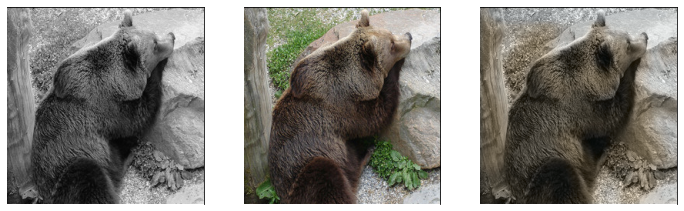

511/511 [==============================] - 706s 1s/step - loss: 0.0407 - val_loss: 0.0404 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 0s 21ms/step


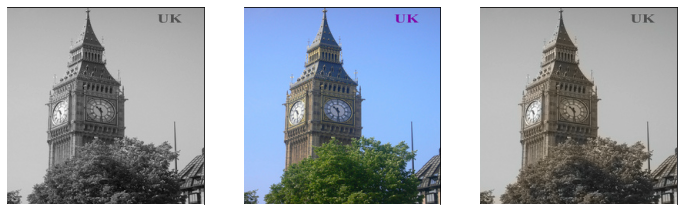

511/511 [==============================] - 680s 1s/step - loss: 0.0401 - val_loss: 0.0407 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 0s 23ms/step


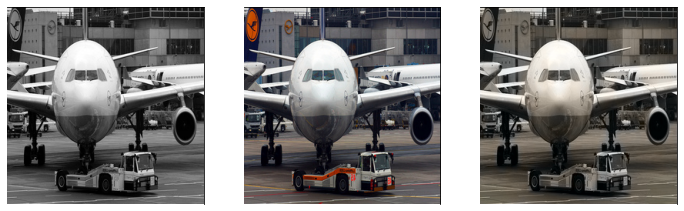

511/511 [==============================] - 683s 1s/step - loss: 0.0397 - val_loss: 0.0399 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 0s 21ms/step


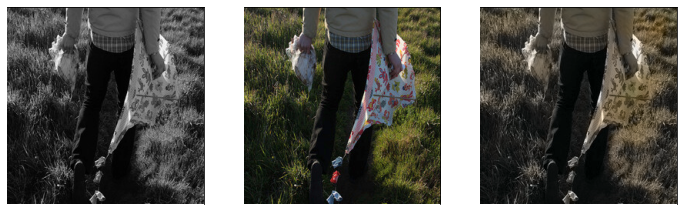

511/511 [==============================] - 674s 1s/step - loss: 0.0393 - val_loss: 0.0391 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 0s 23ms/step


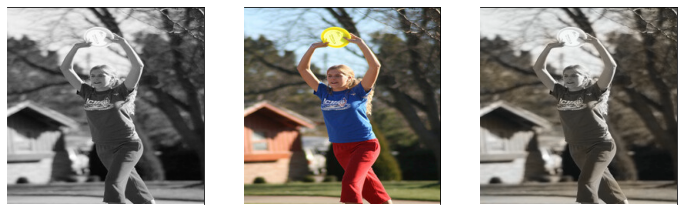

511/511 [==============================] - 669s 1s/step - loss: 0.0391 - val_loss: 0.0401 - lr: 0.0010
Epoch 6/20
1/1 [==============================] - 0s 21ms/step


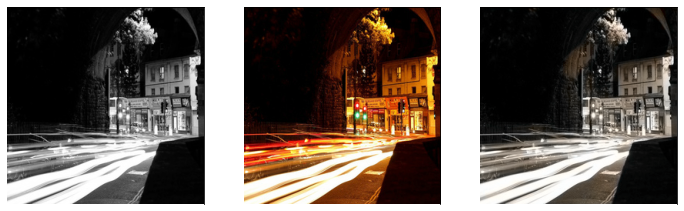

511/511 [==============================] - 674s 1s/step - loss: 0.0388 - val_loss: 0.0389 - lr: 0.0010
Epoch 7/20
1/1 [==============================] - 0s 22ms/step


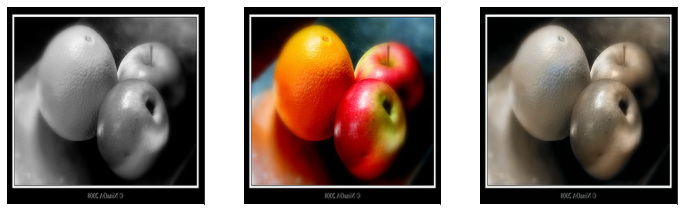

511/511 [==============================] - 673s 1s/step - loss: 0.0387 - val_loss: 0.0387 - lr: 0.0010
Epoch 8/20
1/1 [==============================] - 0s 23ms/step


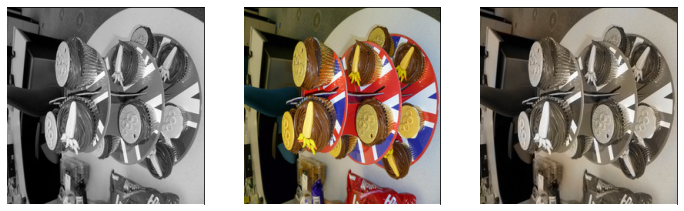

511/511 [==============================] - 673s 1s/step - loss: 0.0384 - val_loss: 0.0386 - lr: 0.0010
Epoch 9/20
1/1 [==============================] - 0s 21ms/step


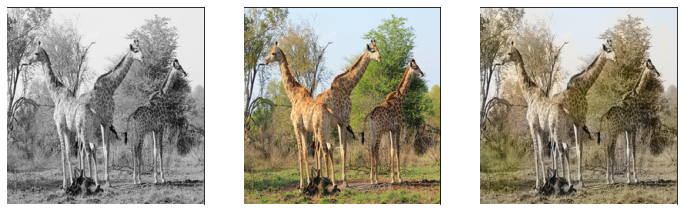

511/511 [==============================] - 678s 1s/step - loss: 0.0383 - val_loss: 0.0386 - lr: 0.0010
Epoch 10/20
1/1 [==============================] - 0s 22ms/step


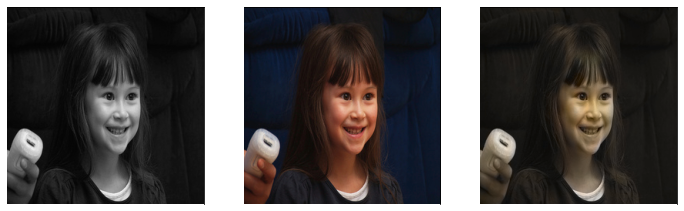

511/511 [==============================] - 677s 1s/step - loss: 0.0381 - val_loss: 0.0382 - lr: 0.0010
Epoch 11/20
1/1 [==============================] - 0s 21ms/step


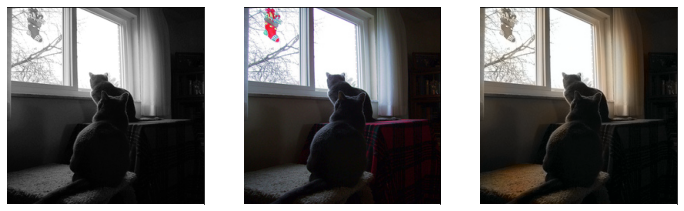

511/511 [==============================] - 673s 1s/step - loss: 0.0379 - val_loss: 0.0382 - lr: 0.0010
Epoch 12/20
1/1 [==============================] - 0s 21ms/step


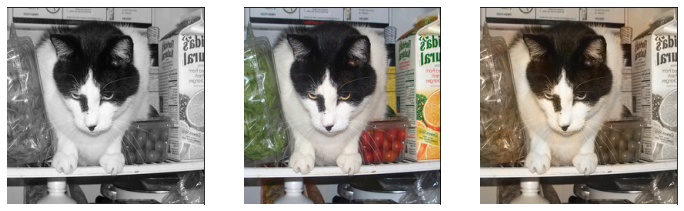

511/511 [==============================] - 671s 1s/step - loss: 0.0378 - val_loss: 0.0379 - lr: 0.0010
Epoch 13/20
1/1 [==============================] - 0s 24ms/step


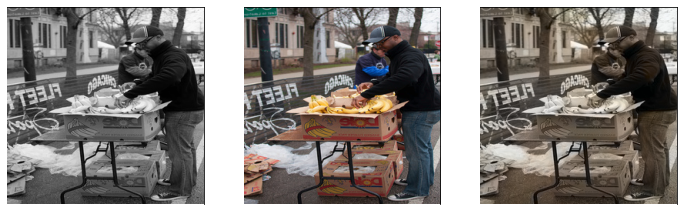

511/511 [==============================] - 674s 1s/step - loss: 0.0376 - val_loss: 0.0378 - lr: 0.0010
Epoch 14/20
1/1 [==============================] - 0s 23ms/step


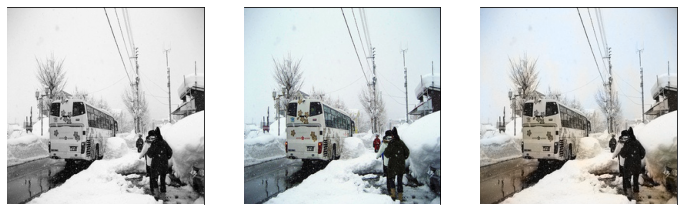

511/511 [==============================] - 672s 1s/step - loss: 0.0374 - val_loss: 0.0375 - lr: 0.0010
Epoch 15/20
1/1 [==============================] - 0s 21ms/step


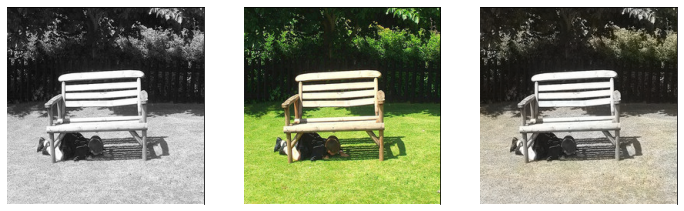

511/511 [==============================] - 673s 1s/step - loss: 0.0372 - val_loss: 0.0374 - lr: 0.0010
Epoch 16/20
1/1 [==============================] - 0s 21ms/step


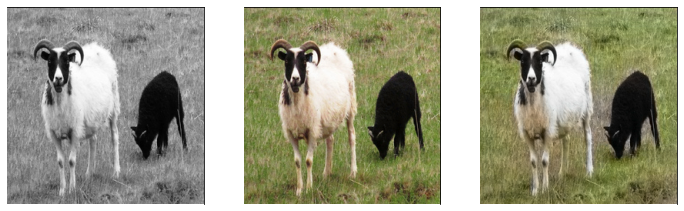

511/511 [==============================] - 668s 1s/step - loss: 0.0371 - val_loss: 0.0373 - lr: 0.0010
Epoch 17/20
1/1 [==============================] - 0s 22ms/step


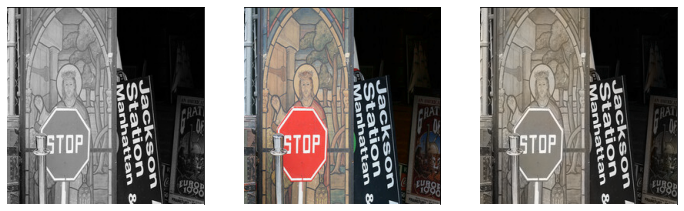

511/511 [==============================] - 667s 1s/step - loss: 0.0370 - val_loss: 0.0374 - lr: 0.0010
Epoch 18/20
1/1 [==============================] - 0s 21ms/step


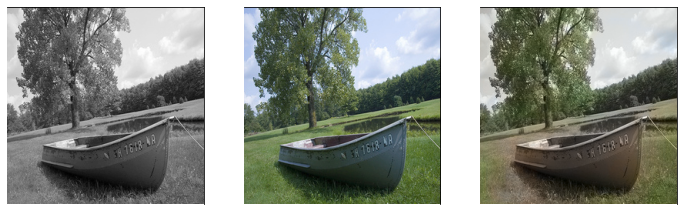

511/511 [==============================] - 667s 1s/step - loss: 0.0368 - val_loss: 0.0370 - lr: 0.0010
Epoch 19/20
1/1 [==============================] - 0s 21ms/step


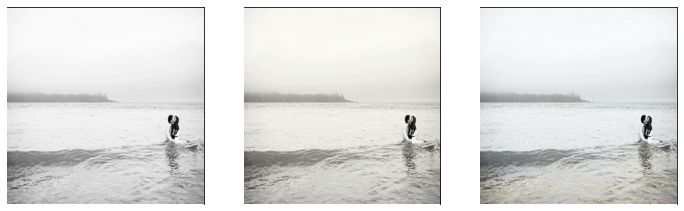

511/511 [==============================] - 668s 1s/step - loss: 0.0367 - val_loss: 0.0373 - lr: 0.0010
Epoch 20/20
1/1 [==============================] - 0s 21ms/step


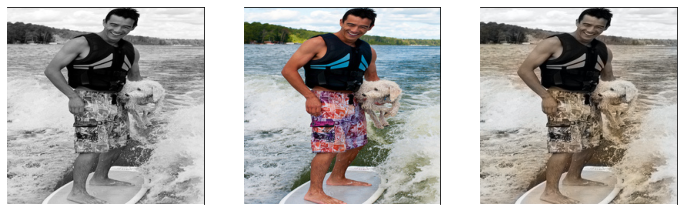

511/511 [==============================] - 665s 1s/step - loss: 0.0366 - val_loss: 0.0370 - lr: 0.0010


In [22]:
model.fit(custom_generator(train_data),
          steps_per_epoch=len(train_data),
          validation_data=custom_generator(valid_data),
          validation_steps=len(valid_data),
          epochs=20,
          verbose=1,
          callbacks=model_callbacks
          )

In [24]:
model.save_weights('weights/full_baseline.h5')

In [26]:
test_data = datagen.flow_from_directory("images/test/", 
                                         class_mode=None, target_size=(256, 256), batch_size=1)

Found 4343 images belonging to 5 classes.


In [ ]:
# for i, imgs in enumerate(custom_generator(test_data)):
#     print(imgs.shape)
#     input, target = imgs
#     L, 
#     print()

1/1 [==============================] - 0s 22ms/step


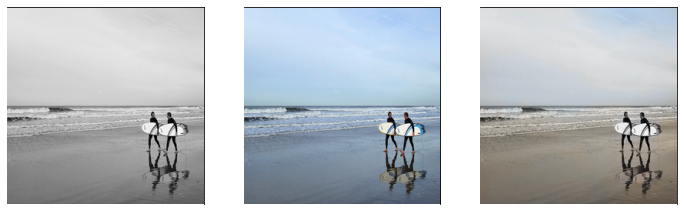

In [34]:
compare_output()

In [ ]:
for i, imgs in enumerate(custom_generator(valid_data)):
  input, ab = imgs
  L, embed = input
  